Setup and Global Helpers

In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import os

# Helper to load images or create a synthetic one if the file is missing
def load_assign_image(path, gray=False):
    if os.path.exists(path):
        img = cv2.imread(path)
        if gray: return cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        return cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    else:
        # Create a synthetic image with shapes for testing
        img = np.zeros((300, 300, 3), dtype=np.uint8)
        cv2.rectangle(img, (50, 50), (250, 250), (200, 200, 200), -1)
        cv2.circle(img, (150, 150), 60, (100, 100, 100), -1)
        if gray: return cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        return img

Question 1 (Intensity Transformations)

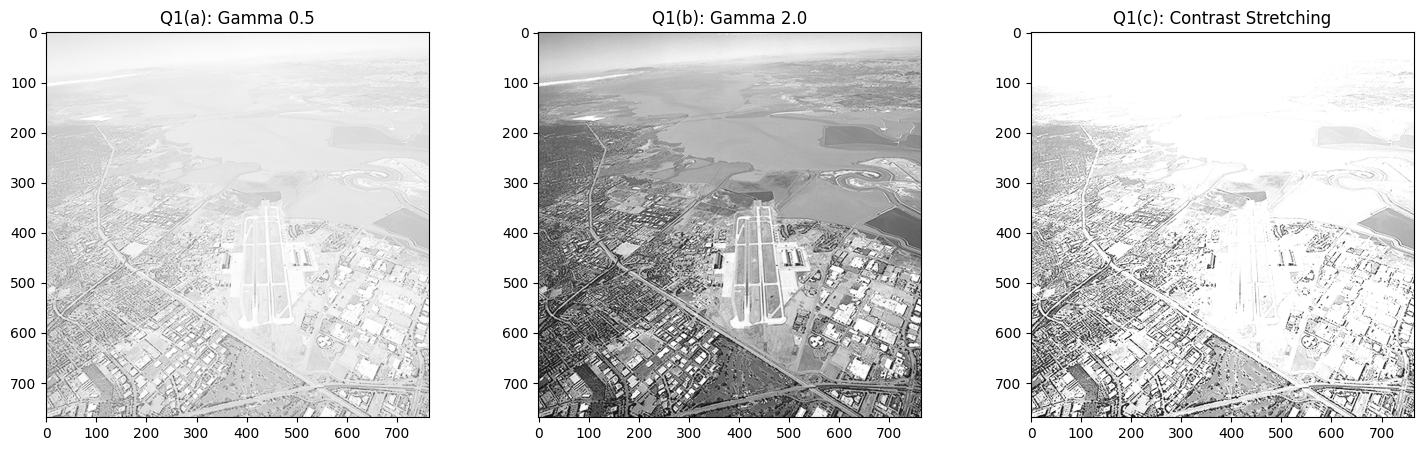

In [2]:
img = load_assign_image('Sources/runway.png', gray=True)
r = img.astype(float) / 255.0

# (a) Gamma 0.5, (b) Gamma 2.0
s05 = np.power(r, 0.5)
s20 = np.power(r, 2.0)

# (c) Contrast Stretching
r1, r2 = 0.2, 0.8
s_stretch = np.where(r < r1, 0, np.where(r > r2, 1, (r - r1) / (r2 - r1)))

fig, axes = plt.subplots(1, 3, figsize=(18, 5))
axes[0].imshow(s05, cmap='gray'); axes[0].set_title('Q1(a): Gamma 0.5')
axes[1].imshow(s20, cmap='gray'); axes[1].set_title('Q1(b): Gamma 2.0')
axes[2].imshow(s_stretch, cmap='gray'); axes[2].set_title('Q1(c): Contrast Stretching')
plt.show()

Question 2 (Lab Color Space Gamma)

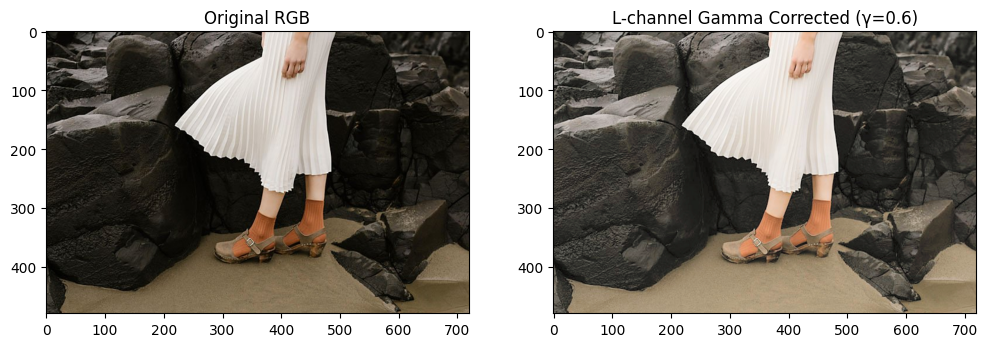

In [3]:
img_rgb = load_assign_image('Sources/highlights_and_shadows.jpg')
# Convert to LAB using OpenCV (Manual conversion is in your lab_gamma_and_hist_eq.py)
img_lab = cv2.cvtColor(img_rgb, cv2.COLOR_RGB2LAB)
l, a, b = cv2.split(img_lab)

# Apply Gamma to L channel (Normalized to 0-1)
gamma = 0.6
l_norm = l.astype(float) / 255.0
l_corr = np.power(l_norm, gamma)
l_final = (l_corr * 255).astype(np.uint8)

# Merge back and show
img_corr_lab = cv2.merge([l_final, a, b])
img_corr_rgb = cv2.cvtColor(img_corr_lab, cv2.COLOR_LAB2RGB)

fig, axes = plt.subplots(1, 2, figsize=(12, 5))
axes[0].imshow(img_rgb); axes[0].set_title('Original RGB')
axes[1].imshow(img_corr_rgb); axes[1].set_title(f'L-channel Gamma Corrected (γ={gamma})')
plt.show()

Question 3 (Manual Histogram Equalization)

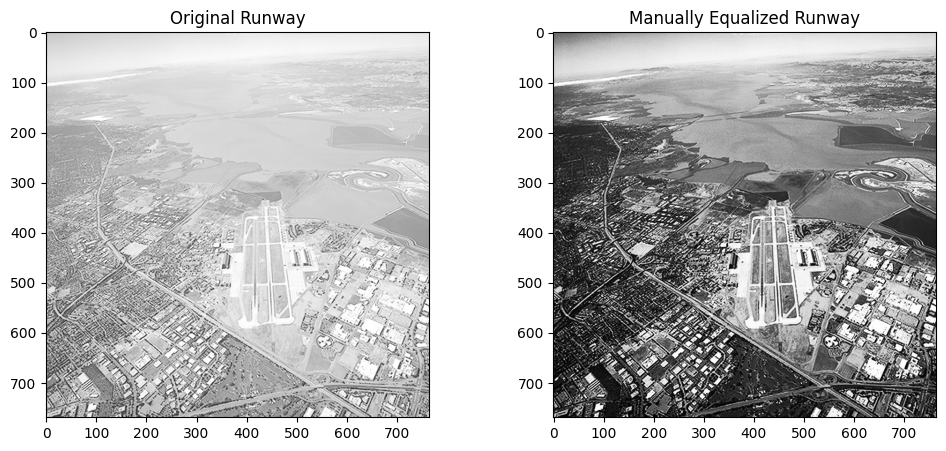

In [4]:
img_gray = load_assign_image('Sources/runway.png', gray=True)

# Manual Histogram Equalization logic
hist, _ = np.histogram(img_gray.flatten(), 256, [0, 256])
cdf = hist.cumsum()
cdf_m = np.ma.masked_equal(cdf, 0)
cdf_m = (cdf_m - cdf_m.min()) * 255 / (cdf_m.max() - cdf_m.min())
cdf_final = np.ma.filled(cdf_m, 0).astype(np.uint8)
img_eq = cdf_final[img_gray]

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1); plt.imshow(img_gray, cmap='gray'); plt.title('Original Runway')
plt.subplot(1, 2, 2); plt.imshow(img_eq, cmap='gray'); plt.title('Manually Equalized Runway')
plt.show()

Question 4 (Otsu Threshold & Masked Equalization)

Otsu Threshold Value: 101.0


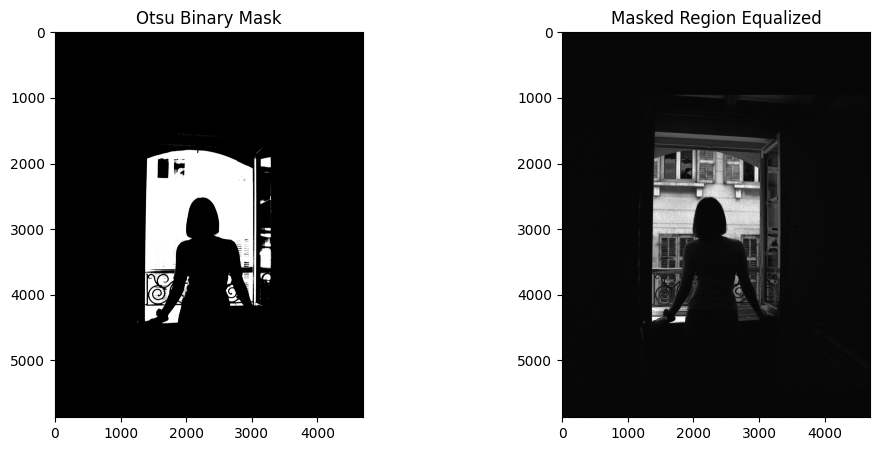

In [5]:
img_q4 = load_assign_image('Sources/looking_out.jpg', gray=True)

# (a) Otsu Thresholding
val, mask = cv2.threshold(img_q4, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
print(f"Otsu Threshold Value: {val}")

# (b) Equalize only the foreground (where mask is white)
res = img_q4.copy()
m_pixels = img_q4[mask == 255]
h_m, _ = np.histogram(m_pixels, 256, [0, 256])
c_m = h_m.cumsum()
c_norm = ((c_m - c_m.min()) * 255 / (m_pixels.size - c_m.min())).astype(np.uint8)
res[mask == 255] = c_norm[img_q4[mask == 255]]

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1); plt.imshow(mask, cmap='gray'); plt.title("Otsu Binary Mask")
plt.subplot(1, 2, 2); plt.imshow(res, cmap='gray'); plt.title("Masked Region Equalized")
plt.show()

REPORT THIS VALUE: Otsu Threshold = 101.0


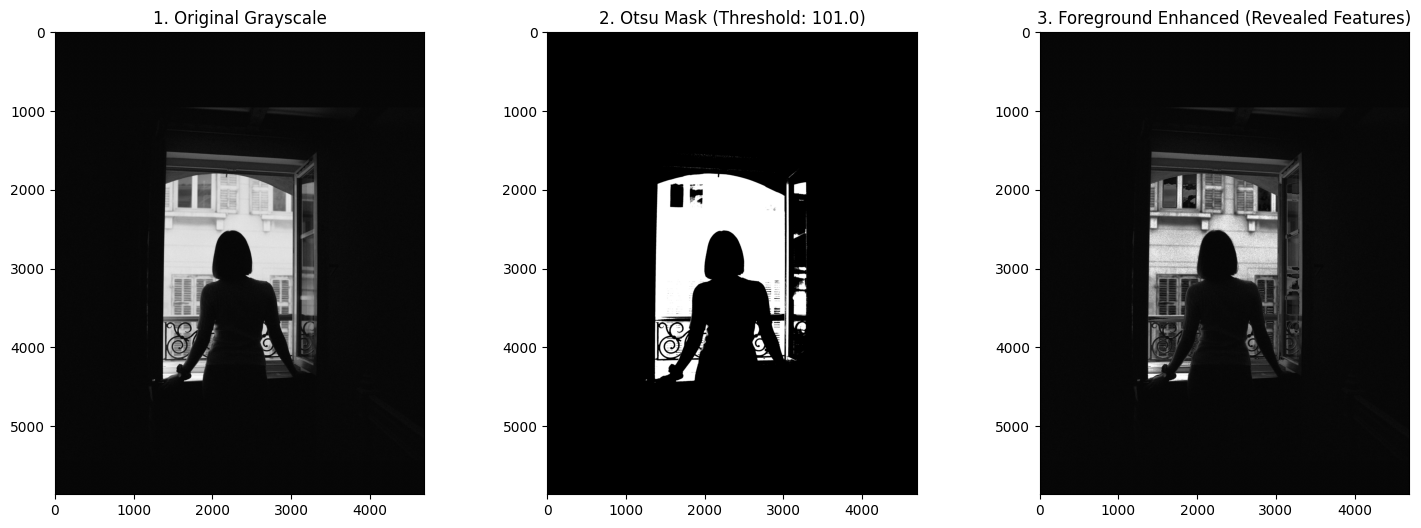

In [12]:
img_q4 = load_assign_image('Sources/looking_out.jpg', gray=True)

# (a) Otsu Thresholding
# This automatically finds the best value to separate the dark room from the bright window
val, mask = cv2.threshold(img_q4, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
print(f"REPORT THIS VALUE: Otsu Threshold = {val}")

# (b) Equalize only the foreground (where mask is 255 / White)
res = img_q4.copy()
m_pixels = img_q4[mask == 255]
h_m, _ = np.histogram(m_pixels, 256, [0, 256])
c_m = h_m.cumsum()

# Normalizing the CDF to the 0-255 range
c_norm = ((c_m - c_m.min()) * 255 / (m_pixels.size - c_m.min())).astype(np.uint8)

# Apply mapping only to the foreground pixels
res[mask == 255] = c_norm[img_q4[mask == 255]]

# Plotting for the report
plt.figure(figsize=(18, 6))
plt.subplot(1, 3, 1); plt.imshow(img_q4, cmap='gray'); plt.title("1. Original Grayscale")
plt.subplot(1, 3, 2); plt.imshow(mask, cmap='gray'); plt.title(f"2. Otsu Mask (Threshold: {val})")
plt.subplot(1, 3, 3); plt.imshow(res, cmap='gray'); plt.title("3. Foreground Enhanced (Revealed Features)")
plt.show()

Question 5 (Gaussian Filtering)

5x5 Normalized Gaussian Kernel:
 [[0.02324684 0.03382395 0.03832756 0.03382395 0.02324684]
 [0.03382395 0.04921356 0.05576627 0.04921356 0.03382395]
 [0.03832756 0.05576627 0.06319146 0.05576627 0.03832756]
 [0.03382395 0.04921356 0.05576627 0.04921356 0.03382395]
 [0.02324684 0.03382395 0.03832756 0.03382395 0.02324684]]


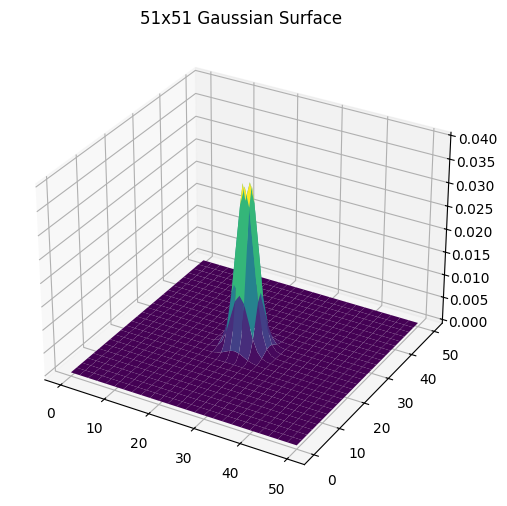

In [6]:
def g_kernel(size, sigma):
    ax = np.linspace(-(size - 1) / 2., (size - 1) / 2., size)
    gauss = np.exp(-0.5 * np.square(ax) / np.square(sigma))
    kernel = np.outer(gauss, gauss)
    return kernel / np.sum(kernel)

# (a) 5x5 Kernel
k5 = g_kernel(5, 2)
print("5x5 Normalized Gaussian Kernel:\n", k5)

# (b) 51x51 Visualization
k51 = g_kernel(51, 2)
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection='3d')
X, Y = np.meshgrid(np.arange(51), np.arange(51))
ax.plot_surface(X, Y, k51, cmap='viridis'); ax.set_title("51x51 Gaussian Surface")
plt.show()

5x5 Manual Kernel:
[[0.02324684 0.03382395 0.03832756 0.03382395 0.02324684]
 [0.03382395 0.04921356 0.05576627 0.04921356 0.03382395]
 [0.03832756 0.05576627 0.06319146 0.05576627 0.03832756]
 [0.03382395 0.04921356 0.05576627 0.04921356 0.03382395]
 [0.02324684 0.03382395 0.03832756 0.03382395 0.02324684]]

Validation: Mean Squared Error between Manual and OpenCV: 0.009657


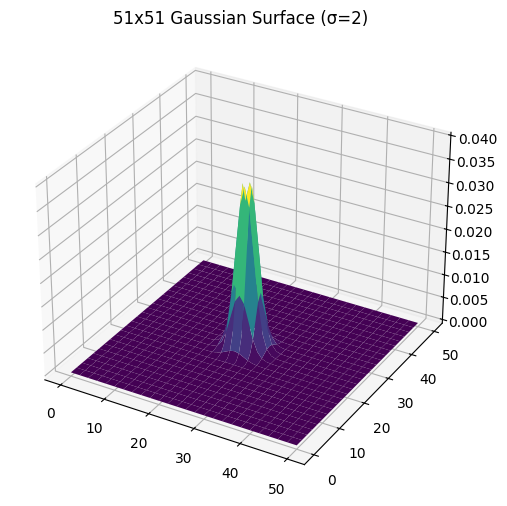

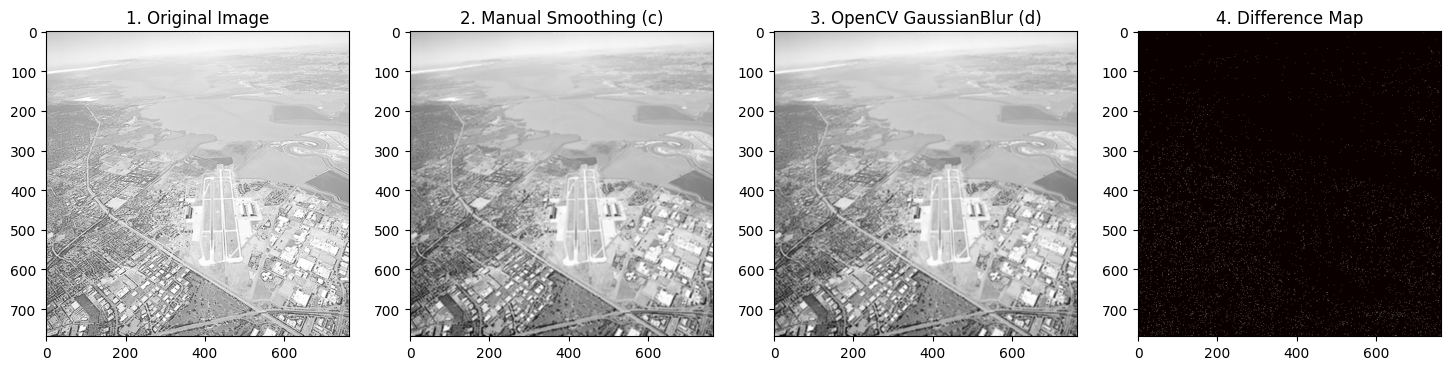

In [13]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# --- (a) Function to compute Normalized Gaussian Kernel ---
def g_kernel(size, sigma):
    ax = np.linspace(-(size - 1) / 2., (size - 1) / 2., size)
    gauss = np.exp(-0.5 * np.square(ax) / np.square(sigma))
    kernel = np.outer(gauss, gauss)
    return kernel / np.sum(kernel)

# Prepare Kernel and Visualization
k5 = g_kernel(5, 2)
k51 = g_kernel(51, 2)

# --- (b) 51x51 Visualization ---
fig = plt.figure(figsize=(14, 6))
ax1 = fig.add_subplot(1, 2, 1, projection='3d')
X, Y = np.meshgrid(np.arange(51), np.arange(51))
ax1.plot_surface(X, Y, k51, cmap='viridis')
ax1.set_title("51x51 Gaussian Surface (σ=2)")

# --- (c) Apply Manually Computed Kernel ---
# Load a grayscale image
img_q5 = load_assign_image('Sources/runway.png', gray=True)

# Use filter2D to apply the custom kernel k5
# -1 means the output image will have the same depth as the input
img_manual = cv2.filter2D(img_q5, -1, k5)

# --- (d) Apply OpenCV's built-in GaussianBlur ---
# Note: For GaussianBlur, ksize must be odd. Sigma is 2 as requested.
img_opencv = cv2.GaussianBlur(img_q5, (5, 5), 2)

# Calculation of Difference (Validation)
mse = np.mean((img_manual.astype(float) - img_opencv.astype(float))**2)
print(f"5x5 Manual Kernel:\n{k5}\n")
print(f"Validation: Mean Squared Error between Manual and OpenCV: {mse:.6f}")

# --- Final Visualization ---
plt.figure(figsize=(18, 6))
plt.subplot(1, 4, 1); plt.imshow(img_q5, cmap='gray'); plt.title("1. Original Image")
plt.subplot(1, 4, 2); plt.imshow(img_manual, cmap='gray'); plt.title("2. Manual Smoothing (c)")
plt.subplot(1, 4, 3); plt.imshow(img_opencv, cmap='gray'); plt.title("3. OpenCV GaussianBlur (d)")

# Show the difference (should be nearly black if identical)
diff = cv2.absdiff(img_manual, img_opencv)
plt.subplot(1, 4, 4); plt.imshow(diff, cmap='hot'); plt.title("4. Difference Map")

plt.show()

Question 6 (Derivative of Gaussian)

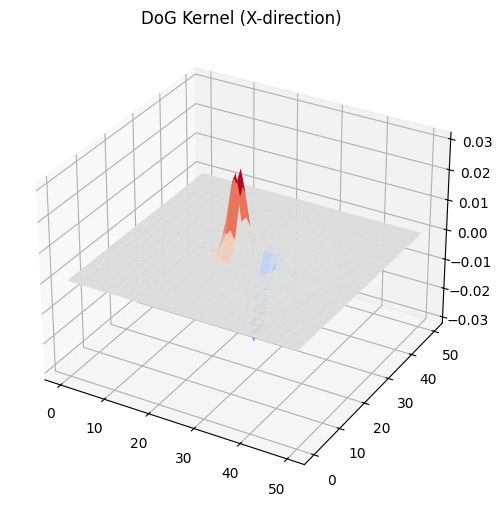

In [7]:
def dog_kernel(size, sigma, dir='x'):
    c = size // 2
    y, x = np.ogrid[-c:c+1, -c:c+1]
    g = np.exp(-(x**2 + y**2)/(2*sigma**2))
    k = -(x/sigma**2)*g if dir=='x' else -(y/sigma**2)*g
    return k / np.sum(np.abs(k))

# 3D Visualization of x-derivative
k_dog = dog_kernel(51, 2, 'x')
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection='3d')
X, Y = np.meshgrid(np.arange(51), np.arange(51))
ax.plot_surface(X, Y, k_dog, cmap='coolwarm'); ax.set_title("DoG Kernel (X-direction)")
plt.show()

6.2

5x5 DoG Kernel (X-direction):
 [[ 0.04413011  0.03210446 -0.         -0.03210446 -0.04413011]
 [ 0.06420893  0.04671172 -0.         -0.04671172 -0.06420893]
 [ 0.07275825  0.05293131 -0.         -0.05293131 -0.07275825]
 [ 0.06420893  0.04671172 -0.         -0.04671172 -0.06420893]
 [ 0.04413011  0.03210446 -0.         -0.03210446 -0.04413011]]


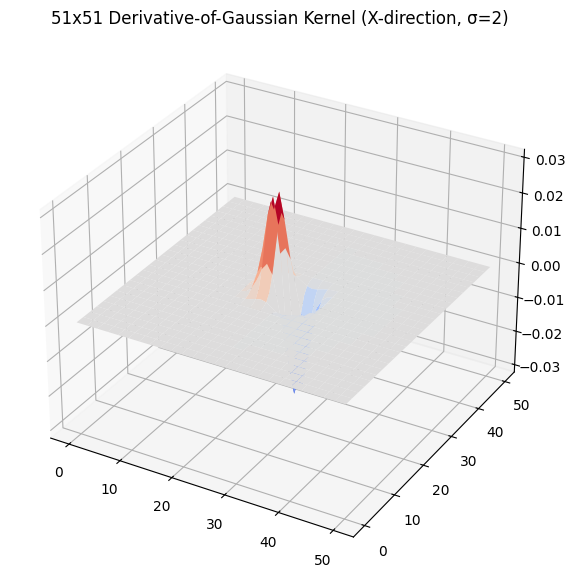

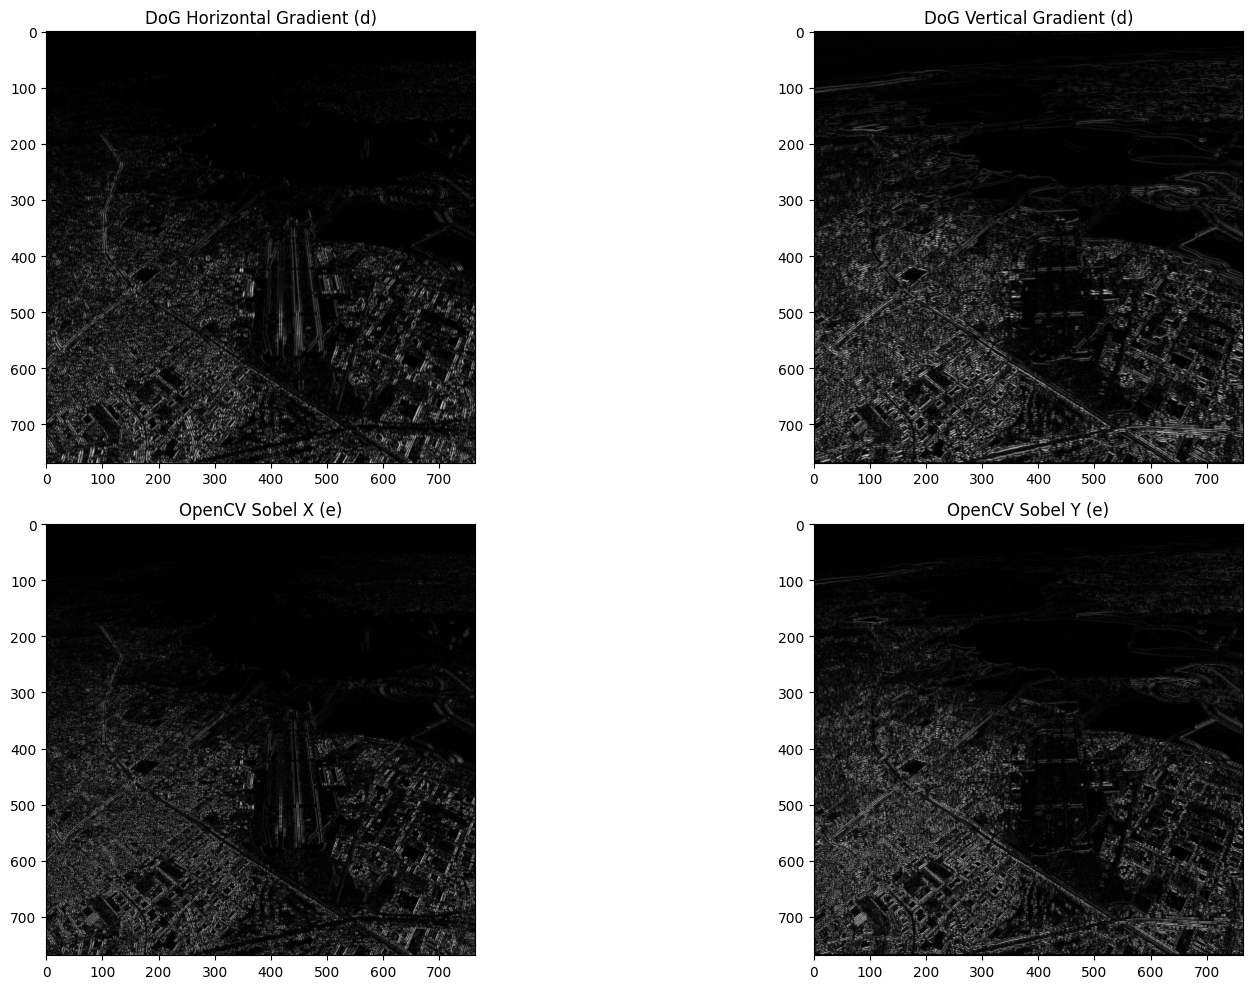

In [14]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# --- (b) Function to compute Normalized Derivative of Gaussian Kernels ---
def dog_kernel(size, sigma, direction='x'):
    c = size // 2
    y, x = np.ogrid[-c:c+1, -c:c+1]

    # Gaussian function (ignoring constant for normalization later)
    g = np.exp(-(x**2 + y**2) / (2 * sigma**2))

    # Partial Derivatives: dG/dx = -(x/sigma^2)*G and dG/dy = -(y/sigma^2)*G
    if direction == 'x':
        k = -(x / sigma**2) * g
    else:
        k = -(y / sigma**2) * g

    # Normalization: Ensure sum of absolute values equals 1 for consistent scale
    return k / np.sum(np.abs(k))

# Compute 5x5 kernels for σ=2
dog_5x5_x = dog_kernel(5, 2, 'x')
dog_5x5_y = dog_kernel(5, 2, 'y')

print("5x5 DoG Kernel (X-direction):\n", dog_5x5_x)

# --- (c) 51x51 Visualization ---
k_viz = dog_kernel(51, 2, 'x')
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')
X, Y = np.meshgrid(np.arange(51), np.arange(51))
ax.plot_surface(X, Y, k_viz, cmap='coolwarm', edgecolor='none')
ax.set_title("51x51 Derivative-of-Gaussian Kernel (X-direction, σ=2)")
plt.show()

# --- (d) Apply DoG Kernels to Image (Gradients) ---
img_q6 = load_assign_image('Sources/runway.png', gray=True)

# Apply manual DoG filters
# We use CV_64F to keep negative values (gradients have direction)
grad_x_dog = cv2.filter2D(img_q6, cv2.CV_64F, dog_5x5_x)
grad_y_dog = cv2.filter2D(img_q6, cv2.CV_64F, dog_5x5_y)

# --- (e) OpenCV Sobel comparison ---
sobel_x = cv2.Sobel(img_q6, cv2.CV_64F, 1, 0, ksize=3)
sobel_y = cv2.Sobel(img_q6, cv2.CV_64F, 0, 1, ksize=3)

# Visualization of results
plt.figure(figsize=(18, 10))

plt.subplot(2, 2, 1); plt.imshow(np.abs(grad_x_dog), cmap='gray'); plt.title("DoG Horizontal Gradient (d)")
plt.subplot(2, 2, 2); plt.imshow(np.abs(grad_y_dog), cmap='gray'); plt.title("DoG Vertical Gradient (d)")
plt.subplot(2, 2, 3); plt.imshow(np.abs(sobel_x), cmap='gray'); plt.title("OpenCV Sobel X (e)")
plt.subplot(2, 2, 4); plt.imshow(np.abs(sobel_y), cmap='gray'); plt.title("OpenCV Sobel Y (e)")

plt.tight_layout()
plt.show()

Question 7 (Zooming) a.


--- Question 7(a): Nearest-Neighbor Interpolation ---
File: taylor_small.jpg
  Scale: 5.00x | SSD (NN): 238.03


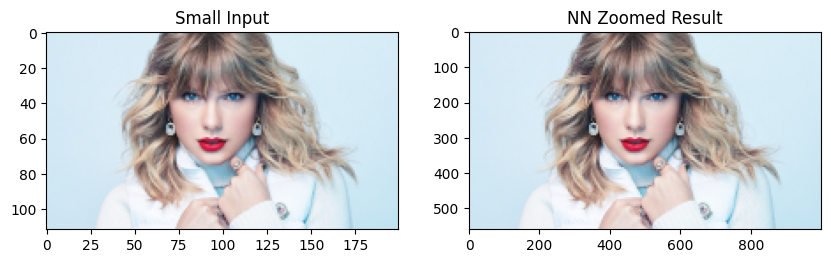

File: taylor_very_small.jpg
  Scale: 20.00x | SSD (NN): 485.89


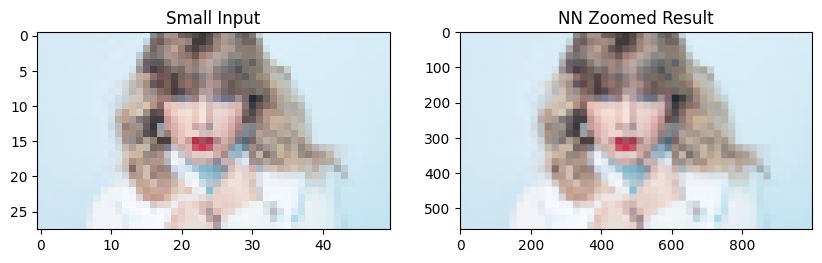

File: im03small.png
  Scale: 4.00x | SSD (NN): 73.17


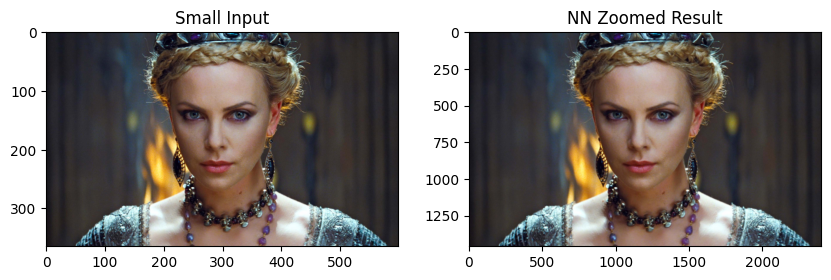

File: im01small.png
  Scale: 4.00x | SSD (NN): 136.27


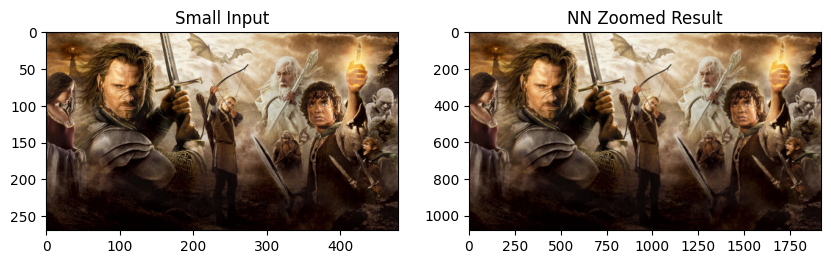

File: im02small.png
  Scale: 4.00x | SSD (NN): 26.45


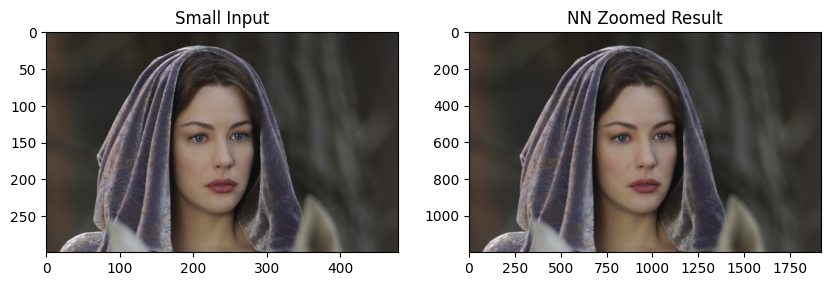

In [18]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import glob
import os

def zoom_nn(img, s, out_h, out_w):
    h, w = img.shape[:2]
    res = np.zeros((out_h, out_w, 3) if len(img.shape)==3 else (out_h, out_w), dtype=img.dtype)
    for i in range(out_h):
        for j in range(out_w):
            # Map back to source coordinates
            src_i = min(int(i / s), h - 1)
            src_j = min(int(j / s), w - 1)
            res[i, j] = img[src_i, src_j]
    return res

def compute_normalized_ssd(img1, img2):
    diff = img1.astype(float) - img2.astype(float)
    return np.sum(diff**2) / img1.size

# Execution for NN
zoom_path = 'Sources/images_for_zooming'
small_files = glob.glob(os.path.join(zoom_path, "*small*"))

print("--- Question 7(a): Nearest-Neighbor Interpolation ---")
for s_file in small_files:
    l_file = s_file.replace('_very_small', '').replace('_small', '').replace('small', '')
    if os.path.exists(l_file):
        img_s = cv2.imread(s_file)
        img_l = cv2.imread(l_file)
        scale = img_l.shape[0] / img_s.shape[0]

        res_nn = zoom_nn(img_s, scale, img_l.shape[0], img_l.shape[1])
        ssd_nn = compute_normalized_ssd(img_l, res_nn)

        print(f"File: {os.path.basename(s_file)}")
        print(f"  Scale: {scale:.2f}x | SSD (NN): {ssd_nn:.2f}")

        # Visualize result
        plt.figure(figsize=(10, 4))
        plt.subplot(1, 2, 1); plt.imshow(cv2.cvtColor(img_s, cv2.COLOR_BGR2RGB)); plt.title("Small Input")
        plt.subplot(1, 2, 2); plt.imshow(cv2.cvtColor(res_nn, cv2.COLOR_BGR2RGB)); plt.title("NN Zoomed Result")
        plt.show()

 bilinear interpolation

--- Question 7(b): Bilinear Interpolation ---
File: taylor_small.jpg
  Scale: 5.00x | SSD (Bilinear): 285.14


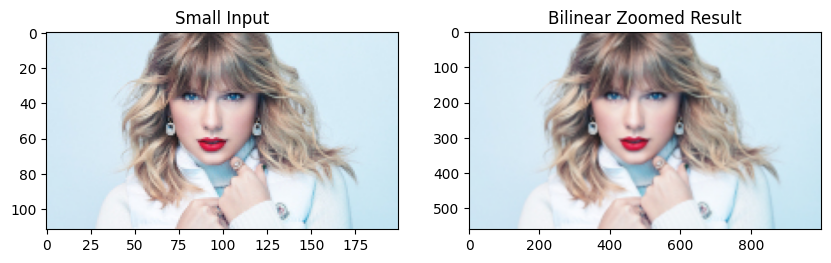

File: taylor_very_small.jpg
  Scale: 20.00x | SSD (Bilinear): 654.60


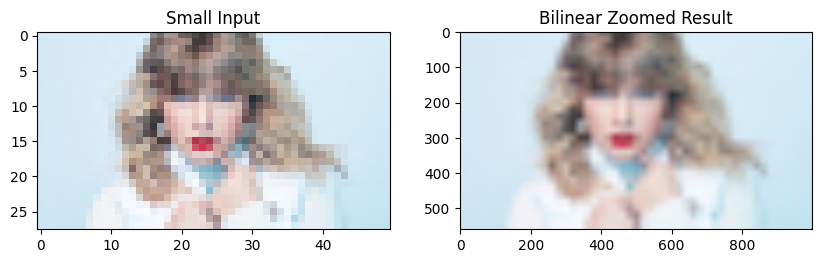

File: im03small.png
  Scale: 4.00x | SSD (Bilinear): 138.78


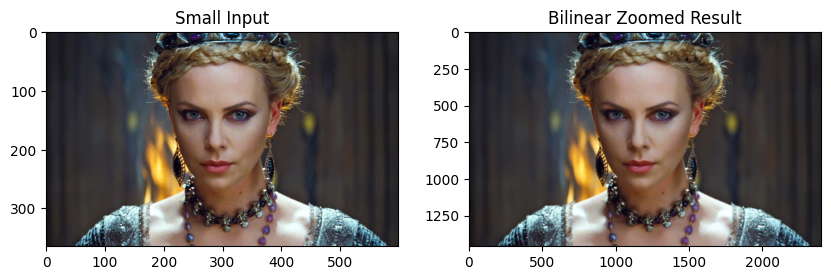

File: im01small.png
  Scale: 4.00x | SSD (Bilinear): 200.25


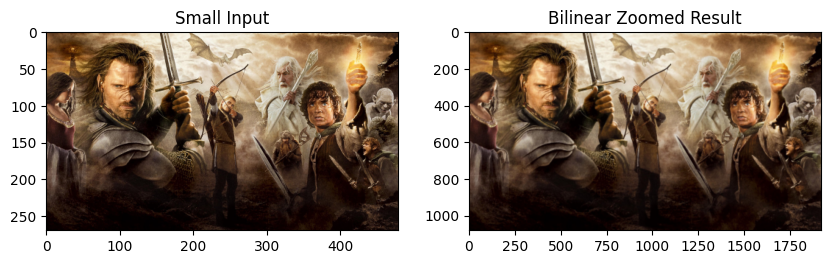

File: im02small.png
  Scale: 4.00x | SSD (Bilinear): 48.96


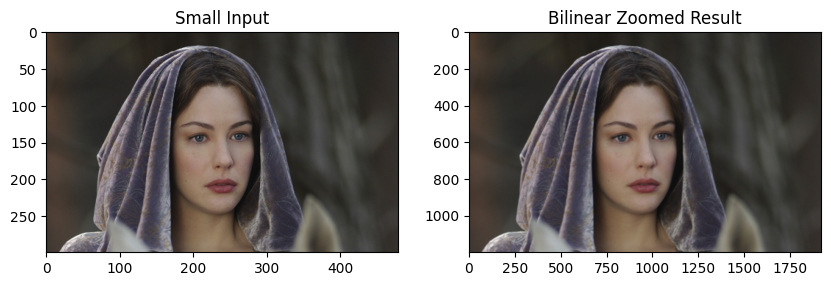

In [19]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import glob
import os

def zoom_bilinear(img, s, out_h, out_w):
    h, w = img.shape[:2]
    res = np.zeros((out_h, out_w, 3) if len(img.shape)==3 else (out_h, out_w), dtype=float)
    for i in range(out_h):
        for j in range(out_w):
            si, sj = i / s, j / s
            i1, j1 = min(int(si), h - 1), min(int(sj), w - 1)
            i2, j2 = min(i1 + 1, h - 1), min(j1 + 1, w - 1)

            # Weights
            di, dj = si - i1, sj - j1

            # Interpolation formula
            res[i, j] = (1-di)*(1-dj)*img[i1,j1] + di*(1-dj)*img[i2,j1] + \
                        (1-di)*dj*img[i1,j2] + di*dj*img[i2,j2]
    return res.astype(np.uint8)

def compute_normalized_ssd(img1, img2):
    diff = img1.astype(float) - img2.astype(float)
    return np.sum(diff**2) / img1.size

# Execution for Bilinear
zoom_path = 'Sources/images_for_zooming'
small_files = glob.glob(os.path.join(zoom_path, "*small*"))

print("--- Question 7(b): Bilinear Interpolation ---")
for s_file in small_files:
    l_file = s_file.replace('_very_small', '').replace('_small', '').replace('small', '')
    if os.path.exists(l_file):
        img_s = cv2.imread(s_file)
        img_l = cv2.imread(l_file)
        scale = img_l.shape[0] / img_s.shape[0]

        res_bi = zoom_bilinear(img_s, scale, img_l.shape[0], img_l.shape[1])
        ssd_bi = compute_normalized_ssd(img_l, res_bi)

        print(f"File: {os.path.basename(s_file)}")
        print(f"  Scale: {scale:.2f}x | SSD (Bilinear): {ssd_bi:.2f}")

        # Visualize result
        plt.figure(figsize=(10, 4))
        plt.subplot(1, 2, 1); plt.imshow(cv2.cvtColor(img_s, cv2.COLOR_BGR2RGB)); plt.title("Small Input")
        plt.subplot(1, 2, 2); plt.imshow(cv2.cvtColor(res_bi, cv2.COLOR_BGR2RGB)); plt.title("Bilinear Zoomed Result")
        plt.show()

Question 8 (Salt and Pepper Noise)

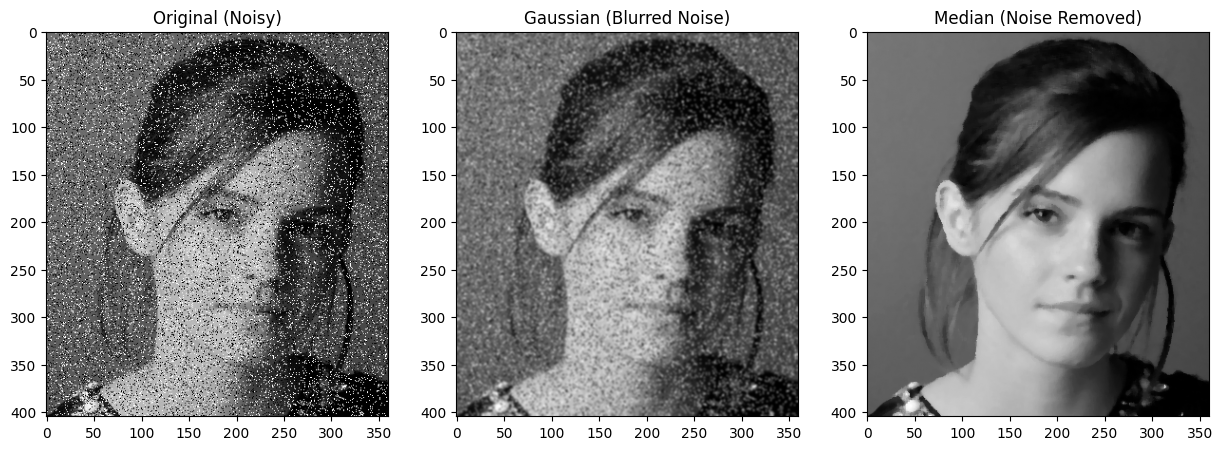

In [9]:
img_q8 = load_assign_image('Sources/emma_salt_pepper.jpg', gray=True)

# Apply Gaussian (Linear) vs Median (Non-linear)
gauss_res = cv2.GaussianBlur(img_q8, (5, 5), 0)
median_res = cv2.medianBlur(img_q8, 5)

plt.figure(figsize=(15, 5))
plt.subplot(1, 3, 1); plt.imshow(img_q8, cmap='gray'); plt.title("Original (Noisy)")
plt.subplot(1, 3, 2); plt.imshow(gauss_res, cmap='gray'); plt.title("Gaussian (Blurred Noise)")
plt.subplot(1, 3, 3); plt.imshow(median_res, cmap='gray'); plt.title("Median (Noise Removed)")
plt.show()

Question 9 (Image Sharpening)

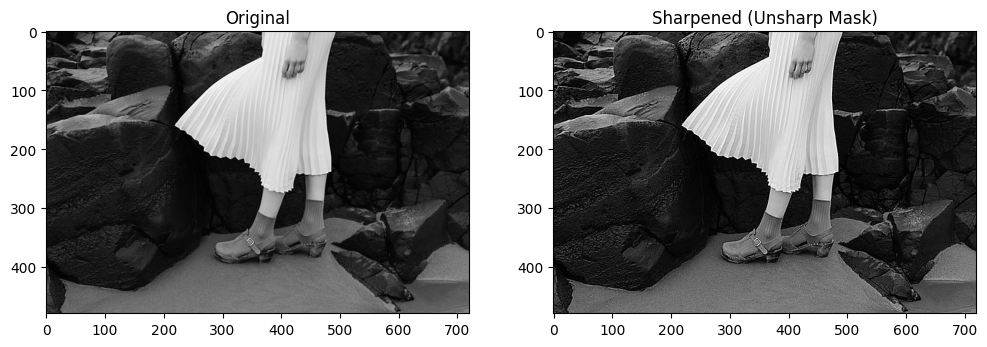

In [22]:
img_q9 = load_assign_image('Sources/highlights_and_shadows.jpg', gray=True)

# Unsharp Masking: Sharpened = Original + strength * (Original - Blurred)
blurred = cv2.GaussianBlur(img_q9, (5, 5), 1.0)
detail = img_q9.astype(float) - blurred.astype(float)
sharpened = np.clip(img_q9.astype(float) + 1.5 * detail, 0, 255).astype(np.uint8)

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1); plt.imshow(img_q9, cmap='gray'); plt.title("Original")
plt.subplot(1, 2, 2); plt.imshow(sharpened, cmap='gray'); plt.title("Sharpened (Unsharp Mask)")
plt.show()

Question 10 (Bilateral Filtering)

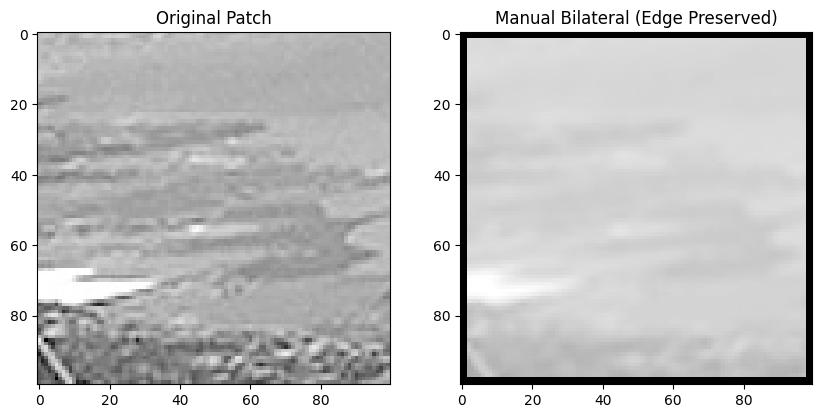

In [11]:
img_q10 = load_assign_image('Sources/runway.png', gray=True)
# Manual bilateral is slow; showing 100x100 patch for instant results
patch = img_q10[100:200, 100:200]

def bilat_func(img, d, s_s, s_r):
    out = np.zeros_like(img, dtype=float)
    rad = d // 2
    for i in range(rad, img.shape[0]-rad):
        for j in range(rad, img.shape[1]-rad):
            reg = img[i-rad : i+rad+1, j-rad : j+rad+1].astype(float)
            # Spatial weights
            y, x = np.ogrid[-rad:rad+1, -rad:rad+1]
            w_s = np.exp(-(x**2 + y**2) / (2 * s_s**2))
            # Intensity weights
            w_r = np.exp(-(reg - img[i, j])**2 / (2 * s_r**2))
            w = w_s * w_r
            out[i, j] = np.sum(reg * w) / np.sum(w)
    return out.astype(np.uint8)

res_bilat = bilat_func(patch, 5, 75, 75)

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1); plt.imshow(patch, cmap='gray'); plt.title("Original Patch")
plt.subplot(1, 2, 2); plt.imshow(res_bilat, cmap='gray'); plt.title("Manual Bilateral (Edge Preserved)")
plt.show()

Applying manual bilateral filter to a 100x100 patch (please wait)...
Manual Bilateral finished in 0.16 seconds.


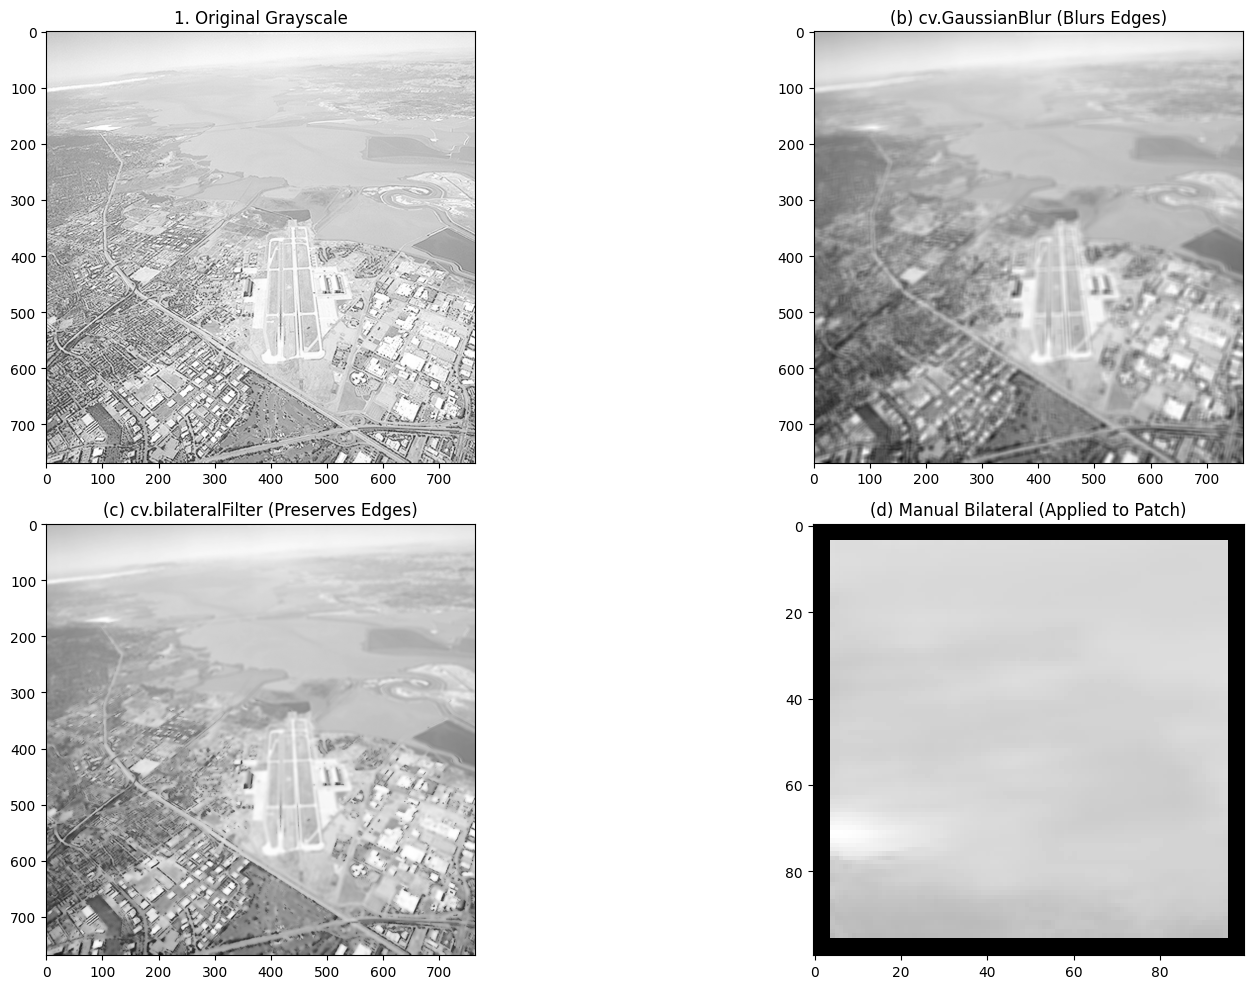

In [23]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import time

# --- (a) Manual Bilateral Filter Function ---
def manual_bilateral_filter(image, d, sigma_s, sigma_r):
    """
    Manually implements bilateral filtering for grayscale images.
    d: diameter of the pixel neighborhood
    sigma_s: spatial standard deviation
    sigma_r: range (intensity) standard deviation
    """
    img = image.astype(np.float32)
    h, w = img.shape
    out = np.zeros_like(img)
    radius = d // 2

    # Pre-compute spatial Gaussian weights (these are constant for every pixel)
    y, x = np.ogrid[-radius : radius + 1, -radius : radius + 1]
    spatial_gaussian = np.exp(-(x**2 + y**2) / (2 * sigma_s**2))

    # Process pixels (skipping boundaries for simplicity)
    for i in range(radius, h - radius):
        for j in range(radius, w - radius):
            # Define the local neighborhood (window)
            neighborhood = img[i - radius : i + radius + 1, j - radius : j + radius + 1]

            # Compute range weights based on intensity difference
            intensity_diff = neighborhood - img[i, j]
            range_gaussian = np.exp(-(intensity_diff**2) / (2 * sigma_r**2))

            # Calculate total weight
            weights = spatial_gaussian * range_gaussian
            normalization_factor = np.sum(weights)

            # Apply weights to the neighborhood
            out[i, j] = np.sum(neighborhood * weights) / normalization_factor

    return out.astype(np.uint8)

# --- Parameters ---
d = 9          # Diameter
sigma_s = 75   # Spatial sigma
sigma_r = 75   # Range/Intensity sigma

# Load grayscale image
img_full = load_assign_image('Sources/runway.png', gray=True)

# Select a 100x100 patch for the manual filter (to save time)
patch = img_full[100:200, 100:200]

# --- (b) Gaussian Smoothing (OpenCV) ---
res_gaussian = cv2.GaussianBlur(img_full, (d, d), sigma_s)

# --- (c) Bilateral Filtering (OpenCV) ---
res_cv_bilateral = cv2.bilateralFilter(img_full, d, sigma_r, sigma_s)

# --- (d) Manual Bilateral Filtering (Part a) ---
print("Applying manual bilateral filter to a 100x100 patch (please wait)...")
start_time = time.time()
res_manual_patch = manual_bilateral_filter(patch, d, sigma_s, sigma_r)
print(f"Manual Bilateral finished in {time.time() - start_time:.2f} seconds.")

# --- Visualization for Report ---
plt.figure(figsize=(18, 10))

# Comparing Full Image Results
plt.subplot(2, 2, 1); plt.imshow(img_full, cmap='gray'); plt.title("1. Original Grayscale")
plt.subplot(2, 2, 2); plt.imshow(res_gaussian, cmap='gray'); plt.title("(b) cv.GaussianBlur (Blurs Edges)")
plt.subplot(2, 2, 3); plt.imshow(res_cv_bilateral, cmap='gray'); plt.title("(c) cv.bilateralFilter (Preserves Edges)")

# Comparing Patch Results (Manual vs Original)
plt.subplot(2, 2, 4); plt.imshow(res_manual_patch, cmap='gray'); plt.title("(d) Manual Bilateral (Applied to Patch)")

plt.tight_layout()
plt.show()